In [21]:
import numpy as np
import dedalus.public as d3
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pathlib
import subprocess
import h5py
import glob

In [108]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

The problem is non-dimensionalized using the box height and freefall time, so
the resulting thermal diffusivity and viscosity are related to the Prandtl
and Rayleigh numbers as:

    kappa = (Rayleigh * Prandtl)**(-1/2)
    nu = (Rayleigh / Prandtl)**(-1/2)

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""

logger = logging.getLogger(__name__)


# Parameters
Lx, Ly, Lz = 4, 4, 1
Nx, Ny, Nz = 12, 12, 12
Rayleigh = 2e6
Prandtl = 1
dealias = 3/2
stop_sim_time = 2
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis, ybasis, zbasis))
b = dist.Field(name='b', bases=(xbasis, ybasis, zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis, ybasis, zbasis))
tau_p = dist.Field(name='tau_p')
tau_b1 = dist.Field(name='tau_b1', bases=(xbasis, ybasis))
tau_b2 = dist.Field(name='tau_b2', bases=(xbasis, ybasis))
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=(xbasis, ybasis))
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=(xbasis, ybasis))

# Substitutions
kappa = (Rayleigh * Prandtl)**(-1/2)
nu = (Rayleigh / Prandtl)**(-1/2)
x, y, z = dist.local_grids(xbasis, ybasis, zbasis)
ex, ey, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = - u@grad(b)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
problem.add_equation("b(z=0) = Lz")
problem.add_equation("u(z=0) = 0")
problem.add_equation("b(z=Lz) = 0")
problem.add_equation("u(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
b['g'] *= z * (Lz - z) # Damp noise at walls
b['g'] += Lz - z # Add linear background

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(u, name='velocity')
snapshots.add_task(d3.curl(u), name='vorticity')


# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2023-05-30 16:16:07,570 subsystems 0/1 INFO :: Building subproblem matrices 1/36 (~3%) Elapsed: 0s, Remaining: 4s, Rate: 8.4e+00/s
2023-05-30 16:16:07,764 subsystems 0/1 INFO :: Building subproblem matrices 4/36 (~11%) Elapsed: 0s, Remaining: 3s, Rate: 1.3e+01/s
2023-05-30 16:16:08,021 subsystems 0/1 INFO :: Building subproblem matrices 8/36 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 1.4e+01/s
2023-05-30 16:16:08,283 subsystems 0/1 INFO :: Building subproblem matrices 12/36 (~33%) Elapsed: 1s, Remaining: 2s, Rate: 1.4e+01/s
2023-05-30 16:16:08,736 subsystems 0/1 INFO :: Building subproblem matrices 16/36 (~44%) Elapsed: 1s, Remaining: 2s, Rate: 1.2e+01/s
2023-05-30 16:16:08,989 subsystems 0/1 INFO :: Building subproblem matrices 20/36 (~56%) Elapsed: 2s, Remaining: 1s, Rate: 1.3e+01/s
2023-05-30 16:16:09,245 subsystems 0/1 INFO :: Building subproblem matrices 24/36 (~67%) Elapsed: 2s, Remaining: 1s, Rate: 1.3e+01/s
2023-05-30 16:16:09,497 subsystems 0/1 INFO :: Building subproblem matric

In [107]:
print(subprocess.check_output("find snapshots | sort", shell=True).decode())

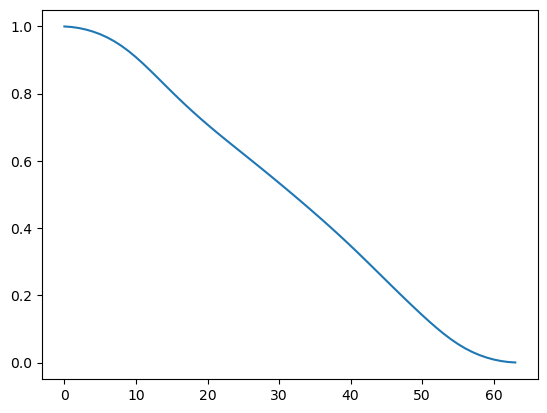

In [35]:
# chebyshev basis cause nonlinear? how to find the correct grid
# avg buoyancy over time, non-changing; apparently
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    buoyancy=file['tasks']['buoyancy'][:,:,:]
    avgb=np.mean(buoyancy,axis=1)
    plt.plot(np.arange(len(avgb[-2,:])),avgb[-2,:])
    plt.show()

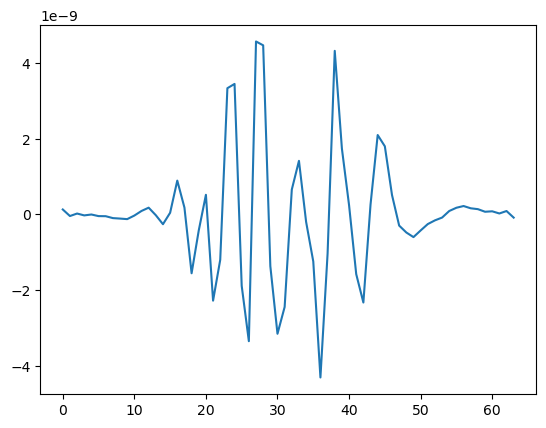

In [61]:
# avg vorticity over time, changing
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgv1=np.mean(vorticity,axis=1)
    plt.plot(np.arange(len(avgv1[2,:])),avgv1[2,:])
    plt.show()
   

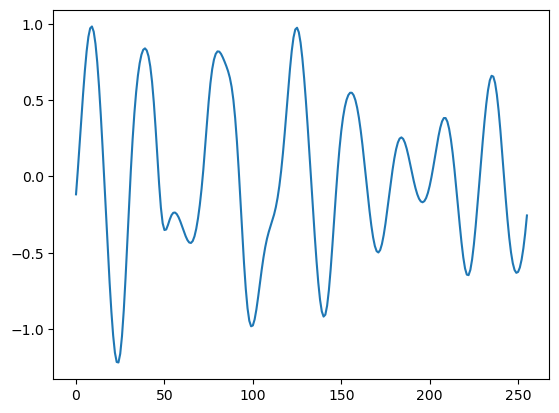

In [37]:
# avg vorticity over time, changing
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    vorticity=file['tasks']['vorticity'][:,:,:]
    avgv2=np.mean(vorticity,axis=2)
    plt.plot(np.arange(len(avgv2[-1,:])),avgv2[-1,:])
    plt.show()
   

In [111]:
# Avg vorticity(z) time animated medium y
files = sorted(glob.glob('snapshots/*.h5'))
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

with h5py.File(files[0], mode='r') as file:
    vorticity=(file['tasks']['vorticity'][:,0,:,int(Ny/2),:]+file['tasks']['vorticity'][:,1,:,int(Ny/2),:]+file['tasks']['vorticity'][:,2,:,int(Ny/2),:])/3
    avgvs=np.mean(vorticity,axis=1)
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        vorticity=(file['tasks']['vorticity'][:,0,:,int(Ny/2),:]+file['tasks']['vorticity'][:,1,:,int(Ny/2),:]+file['tasks']['vorticity'][:,2,:,int(Ny/2),:])/3
        avgv1=np.mean(vorticity,axis=1)
        avgvs=np.append(avgvs,avgv1,axis=0)
        
def update(frame):
    line.set_data(np.arange(len(avgvs[frame, :])), avgvs[frame, :])
    ax.set_xlim(0, len(avgvs[0, :]))
    ax.set_ylim(np.min(avgvs[frame, :])-0.1,np.max(avgvs[frame, :])+0.1)
    ax.set_title('Frame: {}'.format(frame))
    ax.grid(True)  # Add gridlines
    line.set_linewidth(2.5)  # Change line width
    ax.set_xlabel('z')  # Add x-axis label
    ax.set_ylabel('Vorticity')  # Add y-axis label
    return line,

animation = FuncAnimation(fig, update, frames=len(avgvs), interval=100, blit=True)
animation.save('3davg vorticity(z).gif', writer='imagemagick')
plt.show()

2023-05-30 16:21:55,388 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2023-05-30 16:21:55,389 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus '3davg vorticity(z).gif'


<ipython-input-111-221a335ecef9>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [112]:
# Avg vorticity(x) time animated medium y
files = sorted(glob.glob('snapshots/*.h5'))
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

with h5py.File(files[0], mode='r') as file:
    vorticity=(file['tasks']['vorticity'][:,0,:,int(Ny/2),:]+file['tasks']['vorticity'][:,1,:,int(Ny/2),:]+file['tasks']['vorticity'][:,2,:,int(Ny/2),:])/3
    avgvs=np.mean(vorticity,axis=2)
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        vorticity=(file['tasks']['vorticity'][:,0,:,int(Ny/2),:]+file['tasks']['vorticity'][:,1,:,int(Ny/2),:]+file['tasks']['vorticity'][:,2,:,int(Ny/2),:])/3
        avgv1=np.mean(vorticity,axis=2)
        avgvs=np.append(avgvs,avgv1,axis=0)
        
def update(frame):
    line.set_data(np.arange(len(avgvs[frame, :])), avgvs[frame, :])
    ax.set_xlim(0, len(avgvs[0, :]))
    ax.set_ylim(np.min(avgvs[frame, :])-0.1,np.max(avgvs[frame, :])+0.1)
    ax.set_title('Frame: {}'.format(frame))
    ax.grid(True)  # Add gridlines
    line.set_linewidth(2.5)  # Change line width
    ax.set_xlabel('z')  # Add x-axis label
    ax.set_ylabel('Vorticity')  # Add y-axis label
    return line,

animation = FuncAnimation(fig, update, frames=len(avgvs), interval=100, blit=True)
animation.save('3davg vorticity(x).gif', writer='imagemagick')
plt.show()

2023-05-30 16:23:03,253 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2023-05-30 16:23:03,254 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus '3davg vorticity(x).gif'


<ipython-input-112-41282c29b121>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [87]:
#run in cmd
"""

Plot 2D cartesian snapshots.

Usage:
    plot_snapshots.py <files>... [--output=<dir>]

Options:
    --output=<dir>  Output directory [default: ./frames]    
"""

import h5py
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from dedalus.extras import plot_tools


def main(filename, start, count, output):
    """Save plot of specified tasks for given range of analysis writes."""

    # Plot settings
    tasks = ['buoyancy', 'vorticity']
    scale = 1.5
    dpi = 200
    title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
    savename_func = lambda write: 'write_{:06}.png'.format(write)

    # Layout
    nrows, ncols = 2, 1
    image = plot_tools.Box(4, 1)
    pad = plot_tools.Frame(0.3, 0, 0, 0)
    margin = plot_tools.Frame(0.2, 0.1, 0, 0)

    # Create multifigure
    mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
    fig = mfig.figure

    # Plot writes
    with h5py.File(filename, mode='r') as file:
        for index in range(start, start+count):
            for n, task in enumerate(tasks):
                # Build subfigure axes
                i, j = divmod(n, ncols)
                axes = mfig.add_axes(i, j, [0, 0, 1, 1])
                # Call 3D plotting helper, slicing in time
                dset = file['tasks'][task]
                plot_tools.plot_bot_3d(dset, 0, index, axes=axes, title=task, even_scale=True, visible_axes=False)
            # Add time title
            title = title_func(file['scales/sim_time'][index])
            title_height = 1 - 0.5 * mfig.margin.top / mfig.fig.y
            fig.suptitle(title, x=0.44, y=title_height, ha='left')
            # Save figure
            savename = savename_func(file['scales/write_number'][index])
            savepath = output.joinpath(savename)
            fig.savefig(str(savepath), dpi=dpi)
            fig.clear()
    plt.close(fig)


if __name__ == "__main__":

    import pathlib
    from docopt import docopt
    from dedalus.tools import logging
    from dedalus.tools import post
    from dedalus.tools.parallel import Sync

    args = docopt(__doc__)

    output_path = pathlib.Path(args['--output']).absolute()
    # Create output directory if needed
    with Sync() as sync:
        if sync.comm.rank == 0:
            if not output_path.exists():
                output_path.mkdir()
    post.visit_writes(args['<files>'], main, output=output_path)


SyntaxError: invalid syntax (<ipython-input-87-749bc6491d4b>, line 23)

In [4]:
import h5py
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

In [105]:
# Plot settings
tasks = ['buoyancy']
scale = 1.5
dpi = 200
title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
savename_func = lambda write: 'write_{:06}.png'.format(write)

    # Layout
nrows, ncols = 2, 1
image = plot_tools.Box(4, 1)
pad = plot_tools.Frame(0.3, 0, 0, 0)
margin = plot_tools.Frame(0.2, 0.1, 0, 0)

    # Create multifigure
mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
fig = mfig.figure

# Plot writes
with h5py.File('snapshots/snapshots_s1.h5', 'r') as file:
    for index in range(stop_sim_time*4):
        print(index)
        for n, task in enumerate(tasks):
            # Build subfigure axes
            i, j = divmod(n, ncols)
            axes = mfig.add_axes(i, j, [0, 0, 1, 1])
            # Call 3D plotting helper, slicing in time
            dset = file['tasks'][task]
            plot_tools.plot_bot(dset, image_axes=(1,3), data_slices=(index,slice(0,Nx-1),2,slice(0,Ny-1)), axes=axes, title=task, even_scale=True, visible_axes=False)
            # Add time title
        title = title_func(file['scales/sim_time'][index])
        title_height = 1 - 0.5 * mfig.margin.top / mfig.fig.y
        fig.suptitle(title, x=0.44, y=title_height, ha='left')
        # Save figure
        savename = savename_func(file['scales/write_number'][index])
        fig.savefig('3d',dpi=dpi)
        fig.clear()
    plt.close(fig)

0
1
2
3
4
5
6
7


In [61]:
u.evaluate()['c'][3,3,2,5]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [52]:
with h5py.File(files[0], mode='r') as file:
    vorticity=file['tasks']['vorticity']
    print(vorticity.shape)

(8, 3, 12, 12, 12)


In [24]:
# Avg vorticity(z) time animated
files = sorted(glob.glob('snapshots/*.h5'))
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

with h5py.File(files[0], mode='r') as file:
    vorticity=file['tasks']['vorticity'][:,:,1,:]
    avgvs=np.mean(vorticity,axis=1)
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        vorticity=file['tasks']['vorticity'][:,:,1,:]
        avgv1=np.mean(vorticity,axis=1)
        avgvs=np.append(avgvs,avgv1,axis=0)
        
def update(frame):
    line.set_data(np.arange(len(avgvs[frame, :])), avgvs[frame, :])
    ax.set_xlim(0, len(avgvs[0, :]))
    ax.set_ylim(np.min(avgvs[frame, :])-0.1,np.max(avgvs[frame, :])+0.1)
    ax.set_title('Frame: {}'.format(frame))
    ax.grid(True)  # Add gridlines
    line.set_linewidth(2.5)  # Change line width
    ax.set_xlabel('z')  # Add x-axis label
    ax.set_ylabel('Vorticity')  # Add y-axis label
    return line,

animation = FuncAnimation(fig, update, frames=len(avgvs), interval=100, blit=True)
animation.save('avg vorticity(z).gif', writer='imagemagick')
plt.show()

2023-05-30 13:22:44,982 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2023-05-30 13:22:44,983 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus 'avg vorticity(z).gif'
2023-05-30 13:22:45,045 matplotlib.animation 0/1 WARNING :: MovieWriter stderr:
convert: unexpected end-of-file `-': No such file or directory @ error/rgb.c/ReadRGBImage/243.
convert: no images defined `avg vorticity(z).gif' @ error/convert.c/ConvertImageCommand/3235.



CalledProcessError: Command '['convert', '-size', '640x480', '-depth', '8', '-delay', '10.0', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'avg vorticity(z).gif']' returned non-zero exit status 1.